In [1]:
#!pip install matplotlib
from comet_ml import Experiment
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import json
import os
from functools import partial
from collections import defaultdict

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [3]:
experiment = Experiment(
    api_key="1oyzHrJhjofZ4uu1imMYi4y9Y",
    project_name="project-2",
    workspace="d45t4n",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Dastan\\project' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/d45t4n/project-2/c7c249cb54ae44b59acb9faad13c2a8f



In [4]:
data_dir = 'C:/Users/Dastan/project/la5'

In [5]:
len(os.listdir(data_dir))

531

In [6]:
os.listdir(data_dir)[-30:-20]

['LA5_freesurfer_sub-70065_aparc+aseg.nii.gz',
 'LA5_freesurfer_sub-70065_norm.nii.gz',
 'LA5_freesurfer_sub-70068_aparc+aseg.nii.gz',
 'LA5_freesurfer_sub-70068_norm.nii.gz',
 'LA5_freesurfer_sub-70069_aparc+aseg.nii.gz',
 'LA5_freesurfer_sub-70069_norm.nii.gz',
 'LA5_freesurfer_sub-70070_aparc+aseg.nii.gz',
 'LA5_freesurfer_sub-70070_norm.nii.gz',
 'LA5_freesurfer_sub-70072_aparc+aseg.nii.gz',
 'LA5_freesurfer_sub-70072_norm.nii.gz']

In [7]:
import pandas as pd
labels_dir  = 'C:/Users/Dastan/project/'
labels = pd.read_csv(labels_dir + 'LA5_actual_targets.csv')

In [8]:
data_list = pd.DataFrame(columns = ['participant_id','norm','aseg'])

In [9]:
data_list['participant_id'] = labels['participant_id']

In [10]:
from tqdm import tqdm

for i in tqdm(os.listdir(data_dir)):
  for j in range(0, len(data_list['participant_id'])):

    if str(data_list['participant_id'].iloc[j]) in i:
      if 'norm' in i: 
        data_list['norm'].iloc[j] = data_dir +'/'+ i
      elif 'aseg' in i: 
        data_list['aseg'].iloc[j] = data_dir +'/'+ i
      
data_list.dropna(inplace= True)

100%|███████████████████████████████████████████████████████████████████████████████| 531/531 [00:01<00:00, 438.18it/s]


C:\Users\Dastan\AppData\Roaming\Python\Python38\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


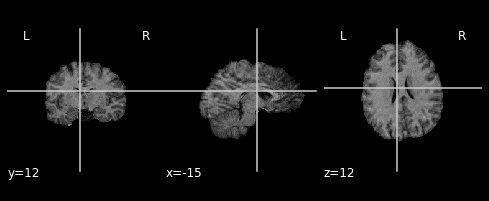

In [11]:
import nilearn
from nilearn import plotting

# visualising normalised image
img = nilearn.image.load_img(data_list['norm'].iloc[0])
plotting.plot_anat(img)

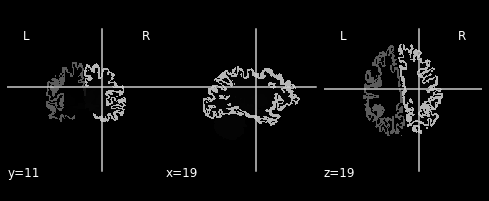

In [12]:
img = nilearn.image.load_img(data_list['aseg'].iloc[0])
plotting.plot_anat(img)

In [13]:
np.unique(img.get_data())

<ipython-input-13-57c23e08da29>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  np.unique(img.get_data())


array([   0,    2,    3,    4,    5,    7,    8,   10,   11,   12,   13,
         14,   15,   16,   17,   18,   24,   26,   28,   30,   31,   41,
         43,   44,   46,   47,   49,   50,   51,   52,   53,   54,   58,
         60,   62,   63,   77,   85,  251,  252,  253,  254,  255, 1000,
       1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032,
       2033, 2034, 2035])

In [14]:
import torchio 
import enum
"""
    Code adapted from: https://github.com/fepegar/torchio#credits

        Credit: Pérez-García et al., 2020, TorchIO: 
        a Python library for efficient loading, preprocessing, 
        augmentation and patch-based sampling of medical images in deep learning.

"""

CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

MRI = 'MRI'
LABEL = 'LABEL'

LIST_ASEG =  [ 8,   10,   11,   12,   13,    16,   17,   18,  26,  47, 49,   50, 
  51,   52,   53,   54,   58,  85,  251,  252,  253,  254,  255] # gray matter segmentation labels

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def get_torchio_dataset(inputs, targets, transform):
    """
    The function creates dataset from the list of files from cunstumised dataloader.
    """
    subjects = []
    for (image_path, label_path) in zip(inputs, targets):
        subject_dict = {
            MRI : torchio.Image(image_path, torchio.INTENSITY),
            LABEL: torchio.Image(label_path, torchio.LABEL),
        }
        subject = torchio.Subject(subject_dict)
        subjects.append(subject)
    
    if transform:
        dataset = torchio.SubjectsDataset(subjects, transform = transform)
    elif not transform:
        dataset = torchio.SubjectsDataset(subjects)
    
    return  dataset , subjects

In [15]:
data, subjects = get_torchio_dataset(data_list['norm'], data_list['aseg'], False)

In [16]:
data[0]['MRI']

Image(shape: (1, 256, 256, 256); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.ByteTensor; memory: 16.0 MiB)

In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

In [18]:
from torch.utils.data import DataLoader, Subset
from torchio import AFFINE, DATA, PATH, TYPE, STEM

Dataset size: 265
Image shape: (1, 256, 256, 256)
Segmentation shape: (1, 256, 256, 256)


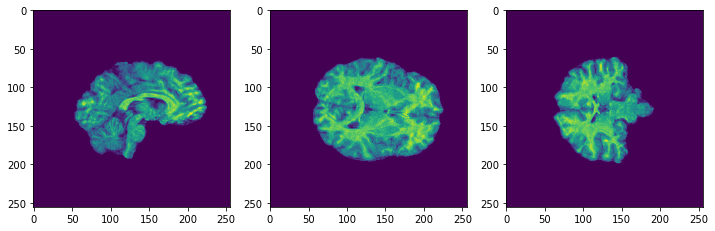

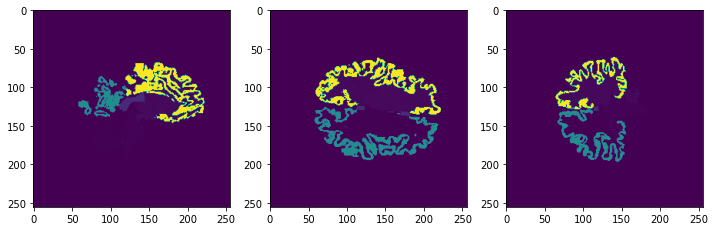

In [19]:
print("Dataset size: {}".format(len(data)))
img = data[0][MRI]
seg = data[0][LABEL]
print("Image shape: {}".format(img.shape))
print("Segmentation shape: {}".format(seg.shape))
plot_central_cuts(img[DATA])
plot_central_cuts(seg[DATA])

In [20]:
experiment.set_name("Whole image based, 1 subject in batch")

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models.vgg import vgg11_bn
from torch.autograd import Function, Variable
import random
import numpy as np

import sys
import os
from optparse import OptionParser

import torch.backends.cudnn as cudnn
from torch import optim
import time

import pandas as pd

In [22]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from unet import UNet

from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from torch.utils.data import DataLoader, Subset
import warnings
import multiprocessing

In [23]:
num_subjects = len(data)
training_split_ratio = 1/2
num_training_subjects = int(training_split_ratio * num_subjects)

# training_subjects = subjects[:num_training_subjects]
# validation_subjects = subjects[num_training_subjects:]

training_subjects = subjects[:20]
validation_subjects = subjects[20:40] # experimenting just on 20 first subjects

training_set = torchio.SubjectsDataset(
    training_subjects, transform=None)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=None)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 20 subjects
Validation set: 20 subjects


In [24]:
training_batch_size = 1
validation_batch_size = 1

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=0,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=0,
)

In [25]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [26]:
def get_iou_score(prediction, ground_truth):
    intersection, union = 0, 0
    intersection += np.logical_and(prediction > 0, ground_truth > 0).astype(np.float32).sum() 
    union += np.logical_or(prediction > 0, ground_truth > 0).astype(np.float32).sum()
    iou_score = float(intersection) / union
    return iou_score

def calculate_metrics(surface, prediction):
    dsc = compute_dice_coefficient(surface, prediction)
    asd_mean, asd_std = compute_average_surface_distance(
        compute_surface_distances(
            surface, prediction, spacing_mm=(1,1,1))
    )
    
    iou = get_iou_score(prediction, surface)
    
    return dsc, asd_mean, asd_std, iou        
        
## see more in https://github.com/deepmind/surface-distance
def validate_dsc_asd(model, loader):
    
    dsc, asd_mean, asd_std, iou = [], [], [], []
    model.eval()

    for batch_idx, batch in enumerate(tqdm(loader)):
            inputs, targets = prepare_batch(batch, device)
            with torch.no_grad():
                logits = forward(model, inputs)
            labels = logits.argmax(dim=CHANNELS_DIMENSION)
            prediction = labels[0].cpu().numpy().astype(np.uint8)
            dsc_temp, asd_mean_temp, asd_std_temp, iou_temp = calculate_metrics(
                targets.cpu().numpy().astype(np.uint8)[0][0], 
                prediction
            )
            dsc.append(dsc_temp)
            asd_mean.append(asd_mean_temp)
            asd_std.append(asd_std_temp)
            iou.append(iou_temp)
    
    return dsc, asd_mean, asd_std, iou

def prepare_batch(batch, device):
    """
    The function loaging *nii.gz files, sending to the devise.
    For the LABEL in binarises the data.
    """
    inputs = batch[MRI][DATA].to(device)
    targets = batch[LABEL][DATA]
    targets[0][0][(np.isin(targets[0][0], LIST_ASEG))] = 1
    targets[targets >= 1000] = 1
    targets[targets != 1] = 0
    targets = targets.to(device)    
    return inputs, targets

def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits

def run_epoch(epoch_idx, action, loader, model, optimizer, scheduler=False, experiment= False):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs.float())
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            
            if is_training:
                batch_loss.backward()
                optimizer.step()
                
            # appending the loss
            epoch_losses.append(batch_loss.item())
           
            if experiment:
                if action == Action.TRAIN:
                    experiment.log_metric("train_dice_loss", batch_loss.item())
                elif action == Action.VALIDATE:
                    experiment.log_metric("validate_dice_loss", batch_loss.item())
                    
            del inputs, targets, logits, probabilities, batch_losses
    
    epoch_losses = np.array(epoch_losses)
#     print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    
    return epoch_losses 

def train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler,
          weights_stem, save_epoch= 1, experiment= False, verbose = True):
    
    start_time = time.time()
    epoch_train_loss, epoch_val_loss = [], []
    
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer, scheduler, experiment)
    
    for epoch_idx in range(1, num_epochs + 1):
        
        epoch_train_losses = run_epoch(epoch_idx, Action.TRAIN, training_loader, 
                                       model, optimizer, scheduler, experiment)
        epoch_val_losses = run_epoch(epoch_idx, Action.VALIDATE, validation_loader, 
                                     model, optimizer, scheduler, experiment)
        
        # 4. Print metrics
        if verbose:
            clear_output(True)
            print("Epoch {} of {} took {:.3f}s".format(epoch_idx, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(epoch_train_losses[-1]))
            print("  validation loss: \t\t\t{:.6f}".format(epoch_val_losses[-1]))    
        
        epoch_train_loss.append(np.mean(epoch_train_losses))
        epoch_val_loss.append(np.mean(epoch_val_losses))
        
        # 5. Plot metrics
        if verbose:
            plt.figure(figsize=(10, 5))
            plt.plot(epoch_train_loss, label='train')
            plt.plot(epoch_val_loss, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
        
        if scheduler:     
            scheduler.step(np.mean(epoch_val_losses))
        # comet ml
        if experiment:
            experiment.log_epoch_end(epoch_idx)
        #saving the model
        # if (epoch_idx% save_epoch == 0):
        #     torch.save(model.state_dict(), f'weights/{weights_stem}_epoch_{epoch_idx}.pth')

In [27]:
def get_model_and_optimizer(device, num_encoding_blocks=3, out_channels_first_layer=4, patience=3):
  # Better to train with num_encoding_blocks=3, out_channels_first_layer = 16 '''
  
  # repoducibility
  torch.manual_seed(0)
  np.random.seed(0)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
    
  model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=num_encoding_blocks,
        out_channels_first_layer=out_channels_first_layer,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    
  optimizer = torch.optim.AdamW(model.parameters())
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, threshold=0.01)
    
  return model, optimizer, scheduler

model, optimizer, scheduler = get_model_and_optimizer(device)

Epoch 5 of 5 took 5728.502s
  training loss (in-iteration): 	0.851272
  validation loss: 			0.872469


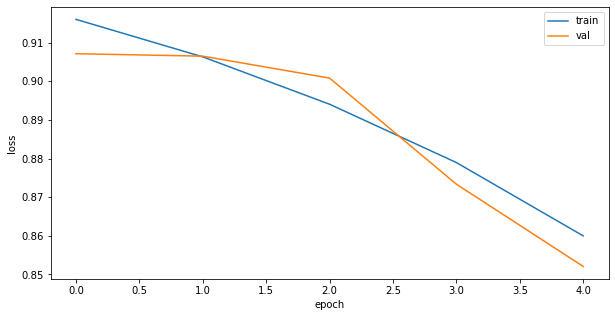

In [28]:
torch.cuda.empty_cache()

num_epochs = 5
weights_stem = 'whole_images'
train(num_epochs, training_loader, validation_loader, model, optimizer, scheduler = False,  weights_stem = weights_stem )

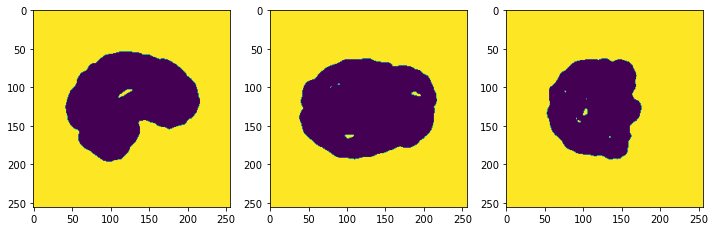

In [30]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    logits = forward(model, inputs.float())
labels = logits.argmax(dim=CHANNELS_DIMENSION)
foreground = labels[0].cpu().numpy().astype(np.uint8)
plot_central_cuts(foreground)

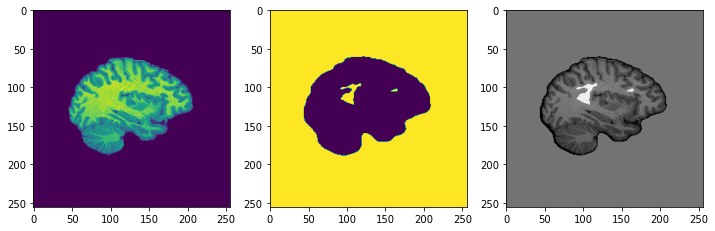

In [31]:
plot_predicted(inputs, foreground, 30, title="")

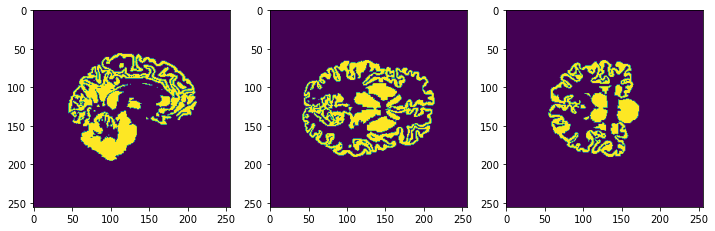

In [32]:
plot_central_cuts(targets[0].cpu())

In [33]:
print(labels[0].size(), targets[0][0].size())
get_dice_score(labels[0],targets)

torch.Size([256, 256, 256]) torch.Size([256, 256, 256])


tensor([[1.6369e-06]])

In [34]:
experiment.set_name("Patch based, 64 batch")

In [35]:
patch_size = 64
samples_per_volume = 8
max_queue_length = 240
training_batch_size = 16
validation_batch_size = 16

patches_training_set = torchio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = torchio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=torchio.sampler.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [37]:
import SimpleITK as sitk

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
        experiment.log_epoch_end(epoch_idx)
        
        
def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs.float())
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
            if action == Action.TRAIN:
                experiment.log_metric("train_dice_loss", batch_loss.item())
            elif action == Action.VALIDATE:
                experiment.log_metric("validate_dice_loss", batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

In [38]:


model, optimizer, scheduler = get_model_and_optimizer(device)

num_epochs = 5

weights_stem = 'patches'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.906
Starting epoch 1


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.893


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.892
Starting epoch 2


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.885


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.878
Starting epoch 3


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.881


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.896
Starting epoch 4


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.886


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.888
Starting epoch 5


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.882


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.73s/it]

Validation mean loss: 0.869


C:\Users\Dastan\anaconda3\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2
C:\Users\Dastan\anaconda3\lib\site-packages\torchio\data\inference\aggregator.py:162: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


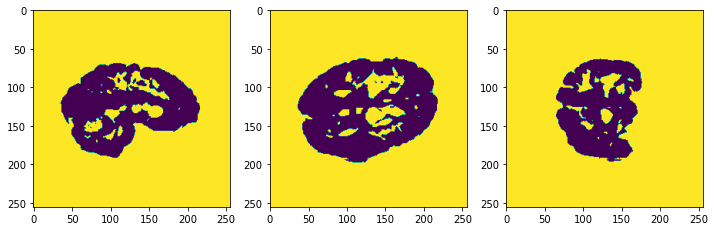

In [39]:
import nibabel as nib
sample = random.choice(validation_set)
input_tensor = sample[MRI][DATA][0]
patch_size = 64, 64, 64  # we can user larger or smaller patches for inference
patch_overlap = 4, 4, 4
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch[MRI][DATA].to(device).float()
        locations = patches_batch['location']
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)
plot_central_cuts(aggregator.get_output_tensor())

In [40]:
model, optimizer, scheduler = get_model_and_optimizer(device)
num_epochs = 40
weights_stem = 'patches'
train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.899
Starting epoch 1


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.886


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.898
Starting epoch 2


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.892


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.871
Starting epoch 3


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.886


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.892
Starting epoch 4


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.892


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.899
Starting epoch 5


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.882


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.864
Starting epoch 6


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.894


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.875
Starting epoch 7


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.888


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.871
Starting epoch 8


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.877


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.865
Starting epoch 9


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.874


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.875
Starting epoch 10


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.864


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.857
Starting epoch 11


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.864


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.869
Starting epoch 12


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.872


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.860
Starting epoch 13


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.835


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.862
Starting epoch 14


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.845


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.854
Starting epoch 15


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.841


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.808
Starting epoch 16


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.854


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.816
Starting epoch 17


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.826


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.804
Starting epoch 18


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.805


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.811
Starting epoch 19


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.781


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.844
Starting epoch 20


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.784


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.804
Starting epoch 21


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.784


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.784
Starting epoch 22


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.798


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.772
Starting epoch 23


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.786


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.784
Starting epoch 24


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.773


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.784
Starting epoch 25


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.747


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.767
Starting epoch 26


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.755


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.741
Starting epoch 27


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.751


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.747
Starting epoch 28


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.715


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.760
Starting epoch 29


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.761


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.782
Starting epoch 30


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.742


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.768
Starting epoch 31


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.737


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.710
Starting epoch 32


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.721


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.757
Starting epoch 33


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.736


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.790
Starting epoch 34


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.700


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.731
Starting epoch 35


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.763


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.735
Starting epoch 36


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.724


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.739
Starting epoch 37


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.698


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.721
Starting epoch 38


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.713


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.697
Starting epoch 39


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.717


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Validation mean loss: 0.734
Starting epoch 40


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Training mean loss: 0.677


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.75s/it]

Validation mean loss: 0.733


C:\Users\Dastan\anaconda3\lib\site-packages\unet\decoding.py:146: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  half_crop = crop // 2
C:\Users\Dastan\anaconda3\lib\site-packages\torchio\data\inference\aggregator.py:162: RuntimeWarning: Medical image frameworks such as ITK do not support int64. Casting to int32...
  warnings.warn(message, RuntimeWarning)


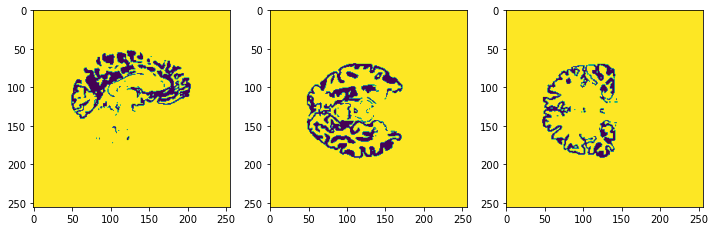

In [41]:
sample = random.choice(validation_set)
input_tensor = sample[MRI][DATA][0]
patch_size = 64, 64, 64  # we can user larger or smaller patches for inference
patch_overlap = 4, 4, 4
grid_sampler = torchio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = torchio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch[MRI][DATA].to(device).float()
        locations = patches_batch['location']
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)
plot_central_cuts(aggregator.get_output_tensor())